# Subproblem B

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Generate data
def generate_data(num_points=100, noise_std=1):
    x = torch.linspace(-1, 1, num_points).unsqueeze(1)
    y = 2*x + torch.cos(25*x) + noise_std * torch.randn_like(x)
    return x, y

# Normalize data

# Split data into training and testing sets
num_train = 15
num_test = 80

x_train, y_train = generate_data(num_train)
x_test, y_test = generate_data(num_test)

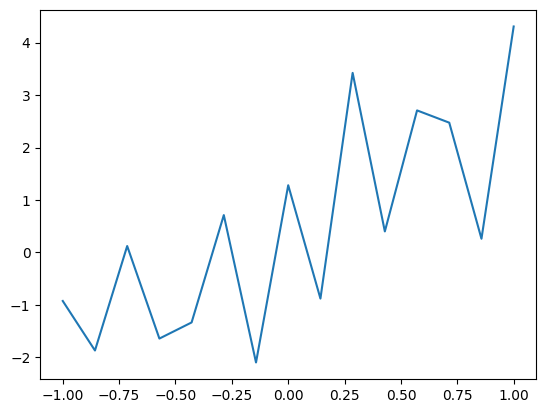

In [ ]:
f1, ax1 = plt.subplots()
ax1.plot(x_train, y_train)

In [ ]:
def create_RFF_features(x, degree, w=None):
  if w is not None:
    x_np = x.numpy()
    omega = w[:degree+1]
    RFF_features = [torch.cos(2*np.pi*omega[i]*x_np.flatten()) for i in range(degree + 1)]
    return torch.tensor(np.column_stack(RFF_features), dtype=torch.float32)
  else:
    x_np = x.numpy()
    w = torch.randn(degree + 1)
    RFF_features = [torch.cos(2*np.pi*w[i]*x_np.flatten()) for i in range(degree + 1)]
    return torch.tensor(np.column_stack(RFF_features), dtype=torch.float32)

In [ ]:
# Solve using Moore-Penrose pseudoinverse with regularization
def solve_with_regularized_pseudoinverse(x_train_poly, y_train, x_test_poly, y_test, lambda_reg=1e-2):
    # Compute regularized pseudoinverse
    I = torch.eye(x_train_poly.size(1))
    gram_matrix = x_train_poly.T @ x_train_poly + lambda_reg * I

    # Check conditioning of the gram matrix
    condition_number = torch.linalg.cond(gram_matrix)
    if condition_number > 1e10:
        print(f"Warning: Ill-conditioned matrix at degree {x_train_poly.size(1) - 1}, condition number: {condition_number}")

    pseudoinverse = torch.linalg.pinv(gram_matrix) @ x_train_poly.T
    weights = pseudoinverse @ y_train

    # Compute predictions
    y_train_pred = x_train_poly @ weights
    y_test_pred = x_test_poly @ weights

    # Compute errors
    train_error = ((y_train - y_train_pred)**2).mean().item()
    test_error = ((y_test - y_test_pred)**2).mean().item()

    return train_error, test_error

In [ ]:
#def solve_with_FBGD(x_train_poly, y_train, x_test_poly, y_test):


In [ ]:
# Train and evaluate models with varying degrees
def train_and_evaluate(max_degree, w=None, lambda_reg=1e-2, use_adam=False):
    train_errors = []
    test_errors = []
    param_counts = []

    for degree in range(1, max_degree + 1):
        print(f"Training model with RFF degree {degree}...")

        # Prepare data with Legendre polynomial features
        x_train_poly = create_RFF_features(x_train, degree, w=w)
        x_test_poly = create_RFF_features(x_test, degree, w=w)

        train_error, test_error = solve_with_regularized_pseudoinverse(
            x_train_poly, y_train, x_test_poly, y_test, lambda_reg=lambda_reg
        )

        # Store errors and parameter counts
        train_errors.append(train_error)
        test_errors.append(test_error)
        param_counts.append((degree + 1))  # Number of parameters = degree + 1

        print(f"Degree {degree} completed. Train Error: {train_error:.6f}, Test Error: {test_error:.6f}\n")

    return param_counts, train_errors, test_errors

Training model with RFF degree 1...
Degree 1 completed. Train Error: 3.988947, Test Error: 2.724080

Training model with RFF degree 2...
Degree 2 completed. Train Error: 3.932962, Test Error: 2.859399

Training model with RFF degree 3...
Degree 3 completed. Train Error: 3.733487, Test Error: 2.826890

Training model with RFF degree 4...
Degree 4 completed. Train Error: 3.696184, Test Error: 2.856497

Training model with RFF degree 5...
Degree 5 completed. Train Error: 3.568309, Test Error: 2.785941

Training model with RFF degree 6...
Degree 6 completed. Train Error: 3.568328, Test Error: 2.785943

Training model with RFF degree 7...
Degree 7 completed. Train Error: 3.531607, Test Error: 2.771289

Training model with RFF degree 8...
Degree 8 completed. Train Error: 3.515133, Test Error: 2.759933

Training model with RFF degree 9...
Degree 9 completed. Train Error: 3.452242, Test Error: 2.735288

Training model with RFF degree 10...
Degree 10 completed. Train Error: 3.440748, Test Error

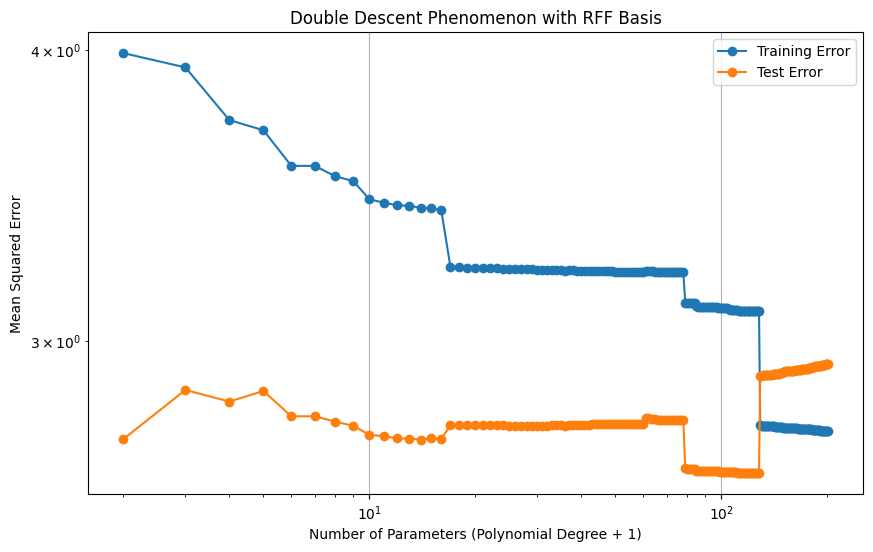

In [ ]:
# Perform experiment
max_degree = 200  # Extend degree range to observe double descent
w = torch.randn(max_degree + 1)
lambda_reg = 1e-1  # Regularization strength
use_adam = False  # Set to True to use Adam optimizer
param_counts, train_errors, test_errors = train_and_evaluate(max_degree, w=w, lambda_reg=lambda_reg, use_adam=use_adam)

# Plot results
plt.figure(figsize=(10, 6))
plt.loglog(param_counts, train_errors, label="Training Error", marker='o')
plt.loglog(param_counts, test_errors, label="Test Error", marker='o')
#plt.ylim([1e-3,100])
plt.xlabel("Number of Parameters (Polynomial Degree + 1)")
plt.ylabel("Mean Squared Error")
plt.title("Double Descent Phenomenon with RFF Basis")
plt.legend()
plt.grid(True)
plt.show()